In [ ]:
# from google.colab import drive
# drive.mount('/content/drive') # We implemented everything on Google Colab

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Read dataset
df = pd.read_csv("/content/drive/MyDrive/ufc-master.csv") # Need to insert the correct path to the dataset file to reproduce everything

df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alex Pereira,Jamahal Hill,-130.0,110.0,76.9231,110.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,3:14,194.0,600.0,650.0,2000.0,1400.0,110.0,200.0
1,Zhang Weili,Yan Xiaonan,-455.0,350.0,21.9780,350.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,200.0,NaN,400.0,NaN,140.0,NaN
2,Justin Gaethje,Max Holloway,-185.0,154.0,54.0541,154.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Blue,...,Punch,5.0,4:59,1499.0,300.0,250.0,2200.0,1600.0,150.0,550.0
3,Charles Oliveira,Arman Tsarukyan,190.0,-218.0,190.0000,45.8716,4/13/2024,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,900.0,330.0,450.0,700.0,550.0,130.0
4,Bo Nickal,Cody Brundage,-1600.0,900.0,6.2500,900.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,3:38,518.0,1000.0,3000.0,-135.0,3000.0,150.0,1400.0




##Exploratory Data Analysis

Dataset Shape: (6185, 118)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6185 entries, 0 to 6184
Columns: 118 entries, RedFighter to BKOOdds
dtypes: bool(1), float64(60), int64(43), object(14)
memory usage: 5.5+ MB
None

Missing Values:
RedFighter             0
BlueFighter            0
RedOdds              133
BlueOdds             134
RedExpectedValue     133
                    ... 
BlueDecOdds         1012
RSubOdds            1225
BSubOdds            1255
RKOOdds             1223
BKOOdds             1256
Length: 118, dtype: int64


<ipython-input-5-690c4fba4dfb>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Winner', data=df, palette=['#0000FF',"#FF0000"])


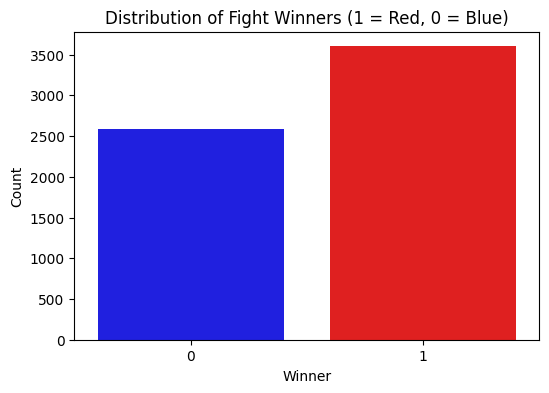

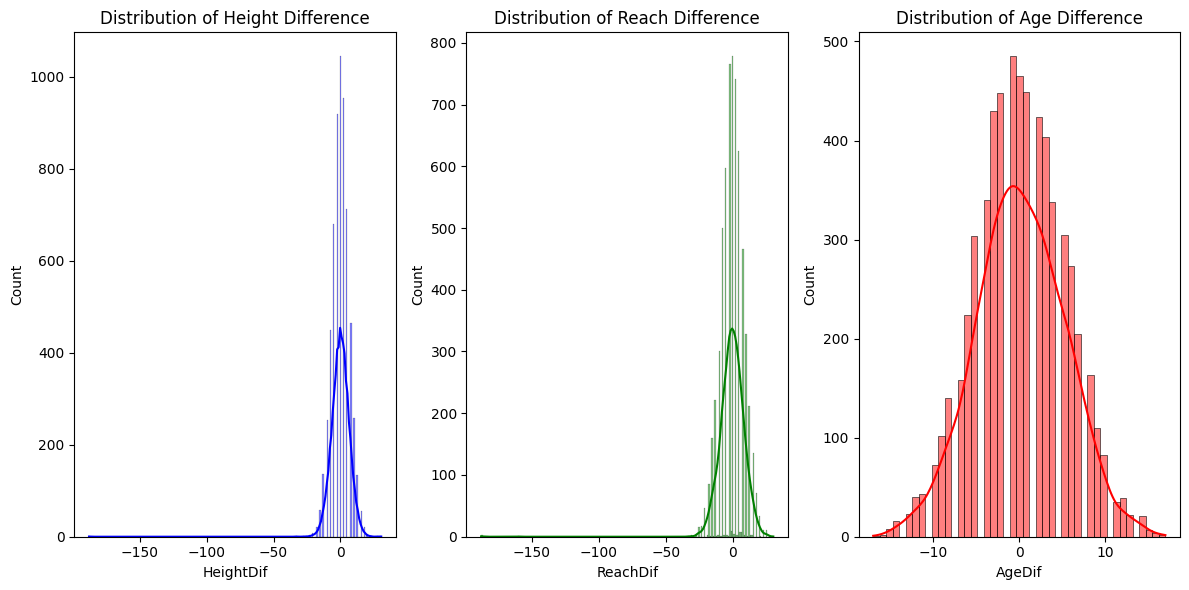

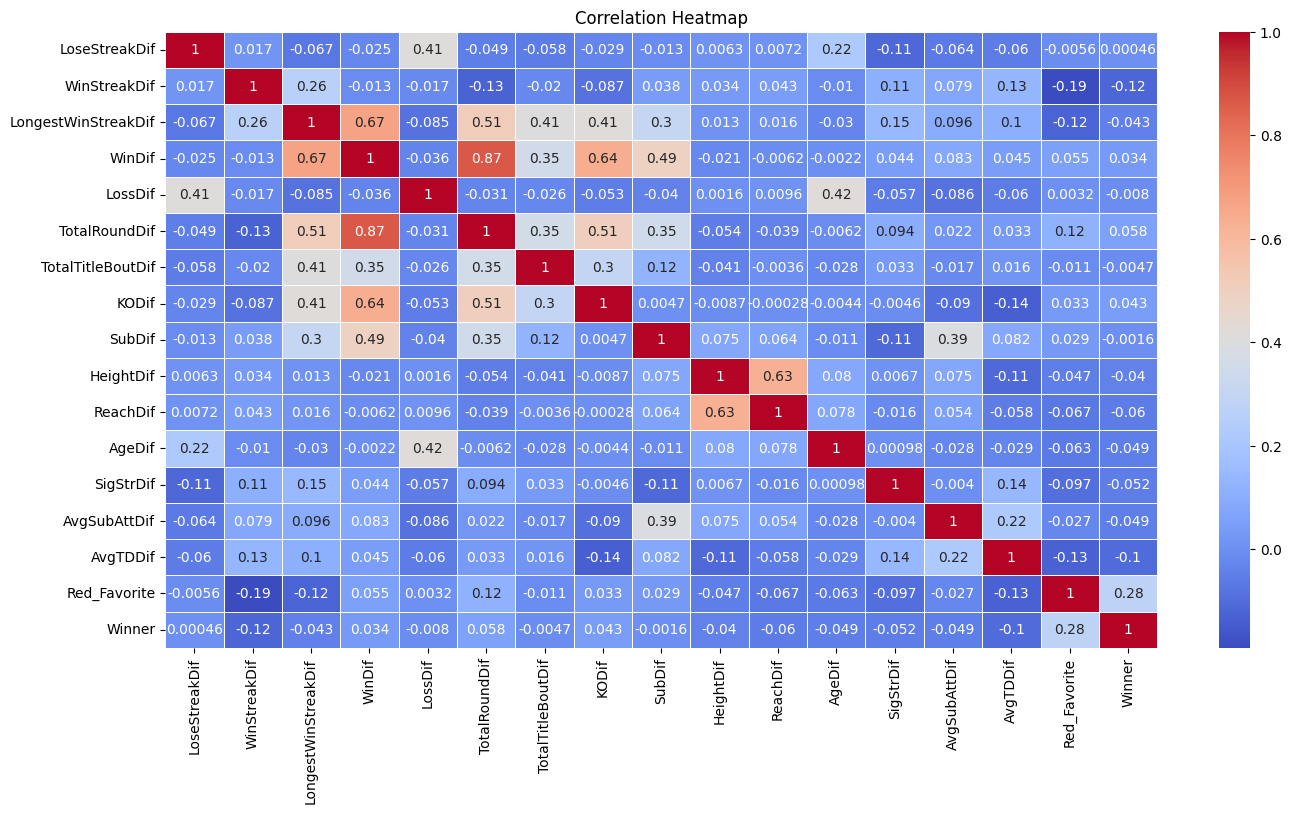

In [ ]:
#General Data Summary
print("Dataset Shape:", df.shape)
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of Target Variable (Winner)
# Convert Winner to binary values (1 for Red, 0 for Blue)
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0

# Plot the distribution of winners (Red vs Blue)
plt.figure(figsize=(6, 4))
sns.countplot(x='Winner', data=df, palette=['#0000FF',"#FF0000"])
plt.title('Distribution of Fight Winners (1 = Red, 0 = Blue)')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

# Feature Distributions
#some numerical features: HeightDif, ReachDif, AgeDif
plt.figure(figsize=(12, 6))

# Height Difference Distribution
plt.subplot(1, 3, 1)
sns.histplot(df['HeightDif'].dropna(), kde=True, color='blue')
plt.title('Distribution of Height Difference')

# Reach Difference Distribution
plt.subplot(1, 3, 2)
sns.histplot(df['ReachDif'].dropna(), kde=True, color='green')
plt.title('Distribution of Reach Difference')

# Age Difference Distribution
plt.subplot(1, 3, 3)
sns.histplot(df['AgeDif'].dropna(), kde=True, color='red')
plt.title('Distribution of Age Difference')

plt.tight_layout()
plt.show()

# Correlation Heatmap
# correlation analysis
df['Red_Favorite'] = df.apply(lambda row: (row.RedOdds < 0)&(row.BlueOdds > 0), axis = 1)
numeric_features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
                    'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
                    'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif', 'Red_Favorite', 'Winner']

# Compute the correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**probability that the lower-ranked player won**




In [ ]:
filtered_df = df[df["BetterRank"] != "neither"]
# the number of rows with rank info
total_row_num = filtered_df.shape[0]

lower_rank_won_num = filtered_df[
    ((filtered_df["BetterRank"] == "Red") & (filtered_df["Winner"] == 0))
    | ((filtered_df["BetterRank"] == "Blue") & (filtered_df["Winner"] == 1))
].shape[0]

print("total_row_num = " + str(total_row_num))
print("lower_rank_won_num = " + str(lower_rank_won_num))

probability = lower_rank_won_num / total_row_num
print(f'The probability that the lower-ranked player won is: {probability}')

total_row_num = 1744
lower_rank_won_num = 702
The probability that the lower-ranked player won is: 0.4025229357798165


**predict winners using only the favorite variable:**



In [ ]:
# Odds Model

# print(df.Winner.unique())

# There are only 6 draws in UFC history, so this outcome can be safely ignored. Those are not in this dataset

# Convert target variable into binary values

df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0

# Drop rows with missing values on odds
df.dropna(subset=['RedOdds', 'BlueOdds'])

# Create feature that says if Red is favorite or no

df['Red_Favorite'] = df.apply(lambda row: (row.RedOdds < 0)&(row.BlueOdds > 0), axis = 1)
df.loc[df['Red_Favorite'] == True, 'Red_Favorite'] = 1
df.loc[df['Red_Favorite'] == False, 'Red_Favorite'] = 0

# Let's see the accuracy of a predictive model based on only one variable: Predict that the favorite to win will win

acc = (df[((df.Red_Favorite == 1) & (df.Winner == 1))|((df.Red_Favorite == 0) & (df.Winner == 0))].shape[0])/(df.shape[0])

print("Betting on the favorite:", acc) # It's actually not too bad, we get a 65% accuracy. So, more often than not, it's a good idea to bet on the favorite

# What if we bet on the underdog? Let's check

acc = (df[((df.Red_Favorite == 1) & (df.Winner == 0))|((df.Red_Favorite == 0) & (df.Winner == 1))].shape[0])/(df.shape[0])
print("Betting on the underdog:", acc) # That is expected, it's just 1 - P(Favorite Wins)

# So, this should be a very useful feature to predict outcomes! But can we do better without using it?

# Let's see!

Betting on the favorite: 0.6544190665342602
Betting on the underdog: 0.3455809334657398


<ipython-input-42-9cd94bd4d08e>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['Red_Favorite'] == True, 'Red_Favorite'] = 1


**chi square analysis**




In [ ]:
#chi square analysis

# Chi-Square Test for Association between WeightClass and Winner using 'df'
weightclass_winner_crosstab_df = pd.crosstab(df['WeightClass'], df['Winner'])
chi2_weightclass_winner_df, p_weightclass_winner_df, dof_weightclass_winner_df, _ = stats.chi2_contingency(weightclass_winner_crosstab_df)

# Chi-Square Test for Association between RedStance and BlueStance using 'df'
red_blue_stance_crosstab_df = pd.crosstab(df['RedStance'], df['BlueStance'])
chi2_red_blue_stance_df, p_red_blue_stance_df, dof_red_blue_stance_df, _ = stats.chi2_contingency(red_blue_stance_crosstab_df)

# Cross-tabulations between Gender, WeightClass, and Winner using 'df'
gender_weightclass_winner_crosstab_df = pd.crosstab([df['Gender'], df['WeightClass']], df['Winner'])

# Display results using 'df'
chi_square_results_df = {
    'Chi2 (WeightClass vs. Winner)': chi2_weightclass_winner_df,
    'p-value (WeightClass vs. Winner)': p_weightclass_winner_df,
    'Degrees of Freedom (WeightClass vs. Winner)': dof_weightclass_winner_df,
    'Chi2 (RedStance vs. BlueStance)': chi2_red_blue_stance_df,
    'p-value (RedStance vs. BlueStance)': p_red_blue_stance_df,
    'Degrees of Freedom (RedStance vs. BlueStance)': dof_red_blue_stance_df
}

chi_square_results_df


{'Chi2 (WeightClass vs. Winner)': 7.867740753470196,
 'p-value (WeightClass vs. Winner)': 0.7953787025832069,
 'Degrees of Freedom (WeightClass vs. Winner)': 12,
 'Chi2 (RedStance vs. BlueStance)': 20.648386748598583,
 'p-value (RedStance vs. BlueStance)': 0.014306522692139282,
 'Degrees of Freedom (RedStance vs. BlueStance)': 9}

## 1. Logistic Regression


**Logistic model using certain features:**

In [ ]:
y = df['Winner'] # Target
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)


X = []
X = df[
        [
            "LoseStreakDif",
            "WinStreakDif",
            "LongestWinStreakDif",
            "WinDif",
            "LossDif",
            "TotalRoundDif",
            "TotalTitleBoutDif",
            "KODif",
            "SubDif",
            "HeightDif",
            "ReachDif",
            "AgeDif",
            "SigStrDif",
            "AvgSubAttDif",
            "AvgTDDif"
#            ,"Red_Favorite"
        ]
    ]

X = pd.DataFrame(
    X,
    columns=[
        "LoseStreakDif",
        "WinStreakDif",
        "LongestWinStreakDif",
        "WinDif",
        "LossDif",
        "TotalRoundDif",
        "TotalTitleBoutDif",
        "KODif",
        "SubDif",
        "HeightDif",
        "ReachDif",
        "AgeDif",
        "SigStrDif",
        "AvgSubAttDif",
        "AvgTDDif"
#       ,"Red_Favorite"
    ],
)

X = sm.add_constant(X) # Add constant

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Coefficients and Odds Ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Training Accuracy: 0.6041795985930064
Test Accuracy: 0.5913978494623656

Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
0                 const     0.160029    1.173545
6         TotalRoundDif     0.014870    1.014981
5               LossDif     0.012642    1.012722
8                 KODif     0.004313    1.004323
13            SigStrDif    -0.003438    0.996568
10            HeightDif    -0.003658    0.996349
4                WinDif    -0.009649    0.990397
9                SubDif    -0.010376    0.989678
11             ReachDif    -0.011838    0.988231
14         AvgSubAttDif    -0.017246    0.982902
12               AgeDif    -0.019852    0.980343
7     TotalTitleBoutDif    -0.033636    0.966923
1         LoseStreakDif    -0.043699    0.957242
3   LongestWinStreakDif    -0.057633    0.943996
2          WinStreakDif    -0.093744    0.910516
15             AvgTDDif    -0.116425    0.890096


** Logistic model using all of the variables including favorite, to compare with previous prediction:**




In [ ]:
# Let's try using a logistic regression with a bunch of features

y = df['Winner'] # Target
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

label_binarizer = LabelBinarizer() # Those are categorical variables

T_bout = label_binarizer.fit_transform(df['TitleBout']) # 1 Yes, 0 No
W_class = label_binarizer.fit_transform(df['WeightClass']) # Bantamweight, Catch Weight, Featherweight, Flyweight, Heavyweight, Light Heavyweight, Lightweight, Middleweight, Welterweight, Women's Bantamweight, Women's Featherweight, Women's Flyweight, Women's Strawweight
G = label_binarizer.fit_transform(df['Gender']) # 1 Male, 0 Female
R_Stance = label_binarizer.fit_transform(df['RedStance']) # Open Stance, Orthodox, Southpaw, Switch
B_stance = label_binarizer.fit_transform(df['BlueStance']) # Open Stance, Orthodox, Southpaw, Switch

X = []
X = np.append(T_bout, W_class, axis = 1)
X = np.append(X, G, axis = 1)
X = np.append(X, R_Stance, axis = 1)
X = np.append(X, B_stance, axis = 1)

X = np.append(X, df[['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
        'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#        ,'Red_Favorite'
        ]], axis = 1)
X = pd.DataFrame(X, columns = ['TitleBout', 'WC_Bantam', 'WC_Catch', 'WC_Feather', 'WC_Fly', 'WC_Heavy',
        'WC_LHeavy', 'WC_Light', 'WC_Middle', 'WC_Welter', 'WC_Bantam_F', 'WC_Feather_F', 'WC_Fly_F', 'WC_Straw_F',
        'Gender', 'R_Stance_Open', 'R_Stance_Ortho', 'R_Stance_South', 'R_Stance_Switch', 'B_Stance_Open', 'B_Stance_Ortho',
        'B_Stance_South', 'B_Stance_Switch', 'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif',
        'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#        ,'Red_Favorite'
        ])

X = sm.add_constant(X) # Add constant

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(train_accuracy, test_accuracy) # So we do not, actually. But we get some interesting insights into what determines a winner!

# Coefficients and Odds Ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


0.6072832609145459 0.5955334987593052

Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
12         WC_Feather_F     0.564766    1.759035
19      R_Stance_Switch     0.269112    1.308802
18       R_Stance_South     0.239480    1.270588
6              WC_Heavy     0.102855    1.108331
1             TitleBout     0.088351    1.092372
2             WC_Bantam     0.082287    1.085768
4            WC_Feather     0.079045    1.082253
17       R_Stance_Ortho     0.057913    1.059623
0                 const     0.055128    1.056676
21       B_Stance_Ortho     0.049756    1.051015
29        TotalRoundDif     0.014546    1.014653
28              LossDif     0.013852    1.013949
23      B_Stance_Switch     0.007766    1.007797
31                KODif     0.004242    1.004251
5                WC_Fly     0.000835    1.000835
20        B_Stance_Open     0.000000    1.000000
22       B_Stance_South    -0.002394    0.997608
36            SigStrDif    -0.

# Decision Tree

Unpruned Tree - Training Accuracy: 0.9989654458928202
Unpruned Tree - Test Accuracy: 0.5376344086021505


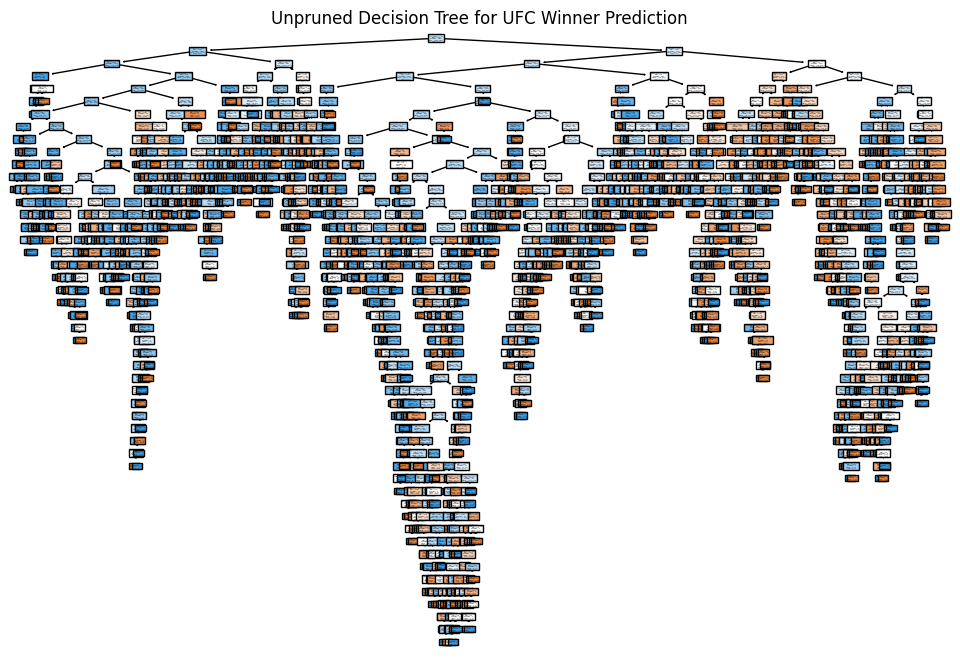

Best ccp_alpha: 0.0014798285767127772
Pruned Tree - Training Accuracy: 0.5861783571280778
Pruned Tree - Test Accuracy: 0.5773366418527709


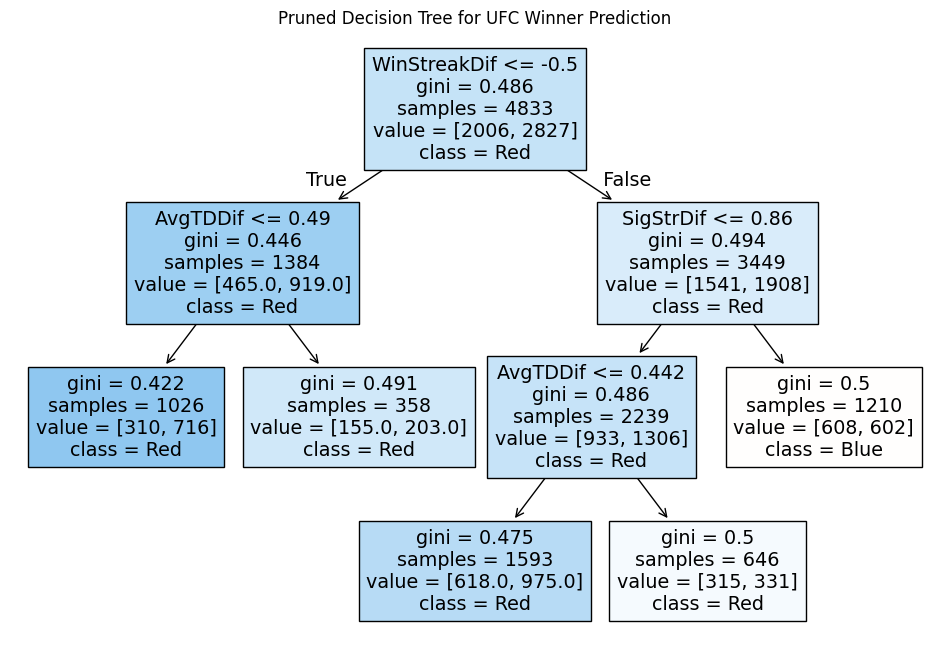

In [ ]:
# BE PATIENT, this took roughly 90s on my computer, 4min here

df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
            'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
            'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
 #           ,"Red_Favorite"
            ]
X = df[features]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Unpruned Tree ###

# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

train_accuracy_unpruned = accuracy_score(
    y_train, y_train_pred_unpruned
)  # obviously overfit the data
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f'Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}')
print(f'Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}')

# Plot the unpruned tree
plt.figure(figsize=(12, 8))
plot_tree(unpruned_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Unpruned Decision Tree for UFC Winner Prediction')
plt.show()


### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a tree for each ccp_alpha and use cross-validation to find the best alpha
clfs = []
cv_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(
        clf, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
    )
    clfs.append(clf)
    cv_scores.append(np.mean(scores))

# Select the best ccp_alpha based on the cross-validation scores
best_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f'Best ccp_alpha: {best_ccp_alpha}')

# Train the final model with the best ccp_alpha on the entire training set
best_clf.fit(X_train, y_train)

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f'Pruned Tree - Training Accuracy: {train_accuracy_pruned}')
print(f'Pruned Tree - Test Accuracy: {test_accuracy_pruned}')

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Pruned Decision Tree for UFC Winner Prediction')
plt.show()

Unpruned Tree - Training Accuracy: 0.9993792675356921
Unpruned Tree - Test Accuracy: 0.575682382133995


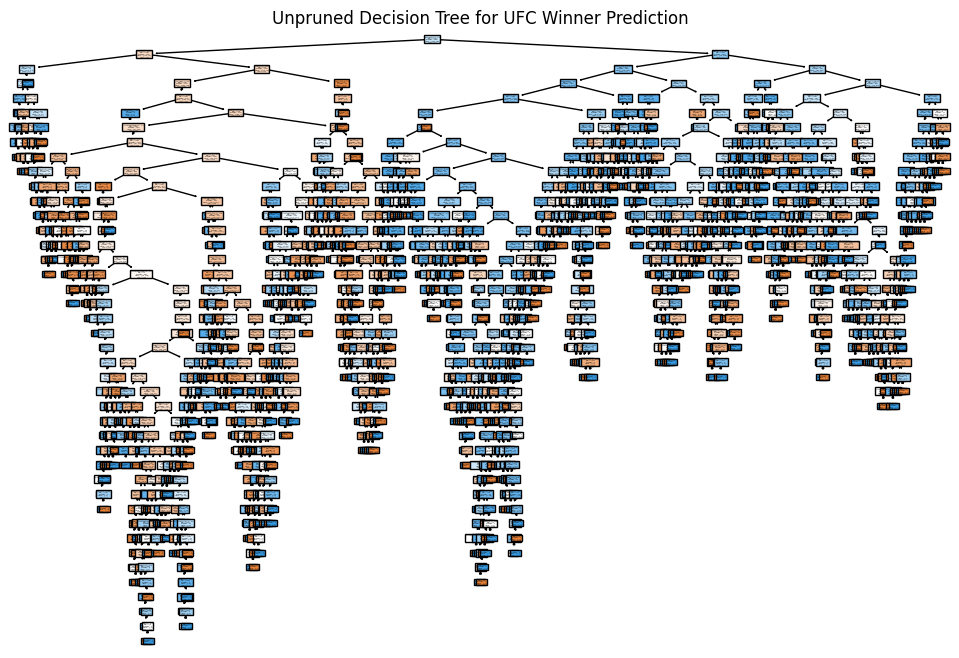

Best ccp_alpha: 0.0019024250301124535
Pruned Tree - Training Accuracy: 0.6559073039519967
Pruned Tree - Test Accuracy: 0.6484698097601324


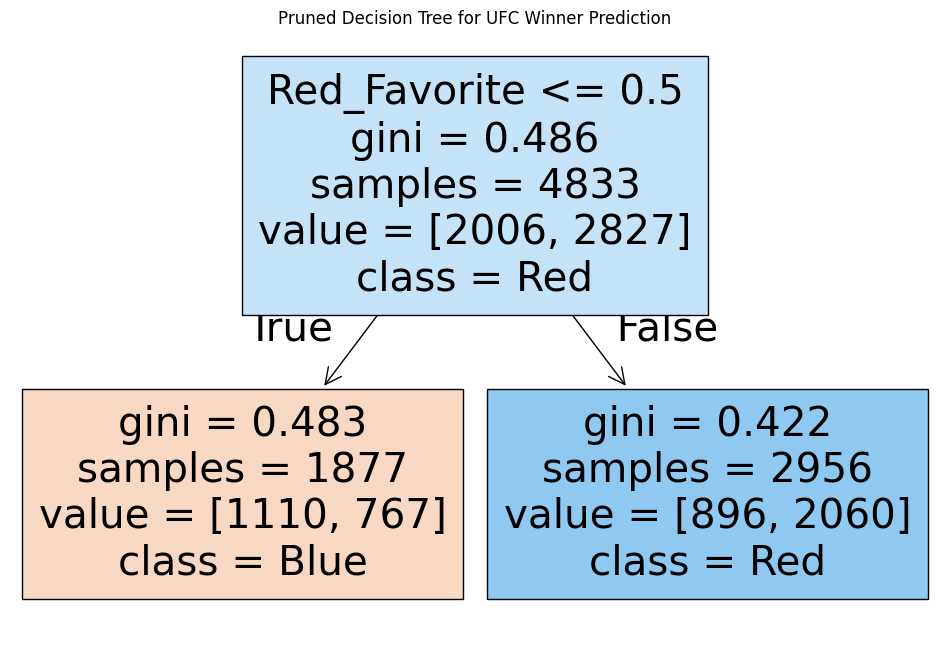

In [ ]:
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
            'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
            'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
           ,"Red_Favorite"
            ]
X = df[features]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Unpruned Tree ###

# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

train_accuracy_unpruned = accuracy_score(
    y_train, y_train_pred_unpruned
)  # obviously overfit the data
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f'Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}')
print(f'Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}')

# Plot the unpruned tree
plt.figure(figsize=(12, 8))
plot_tree(unpruned_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Unpruned Decision Tree for UFC Winner Prediction')
plt.show()


### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a tree for each ccp_alpha and use cross-validation to find the best alpha
clfs = []
cv_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(
        clf, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
    )
    clfs.append(clf)
    cv_scores.append(np.mean(scores))

# Select the best ccp_alpha based on the cross-validation scores
best_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f'Best ccp_alpha: {best_ccp_alpha}')

# Train the final model with the best ccp_alpha on the entire training set
best_clf.fit(X_train, y_train)

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f'Pruned Tree - Training Accuracy: {train_accuracy_pruned}')
print(f'Pruned Tree - Test Accuracy: {test_accuracy_pruned}')

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Pruned Decision Tree for UFC Winner Prediction')
plt.show()

Decision Tree using only stance and weight class

Unpruned Tree - Training Accuracy: 0.595489344092696
Unpruned Tree - Test Accuracy: 0.555004135649297


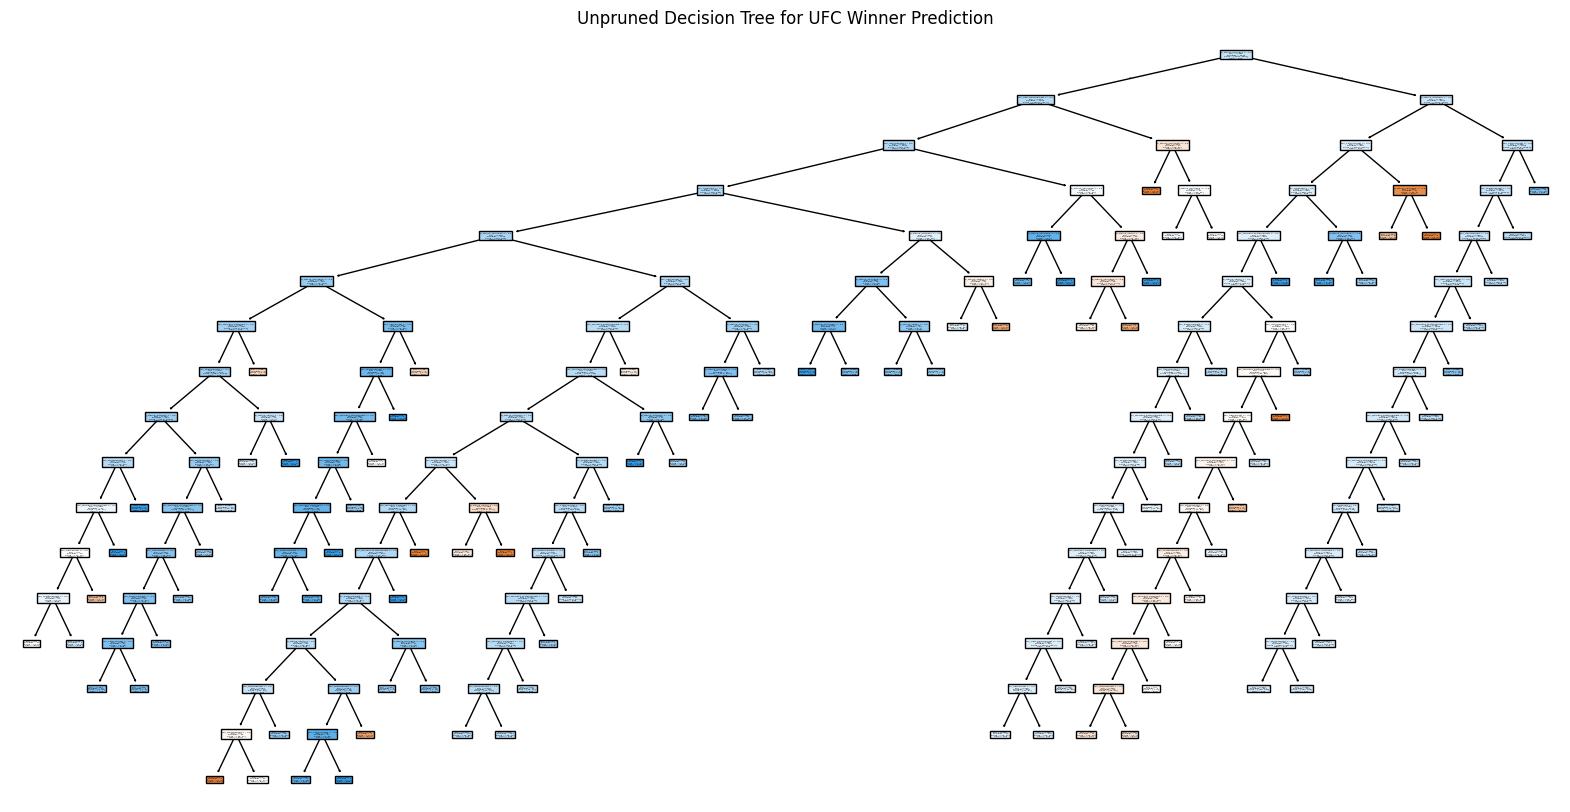

Best ccp_alpha: 0.0006593196131678691
Cross-validated accuracy with best ccp_alpha: 0.5855584174229918
Pruned Tree - Training Accuracy: 0.5867990895923857
Pruned Tree - Test Accuracy: 0.5748552522746071


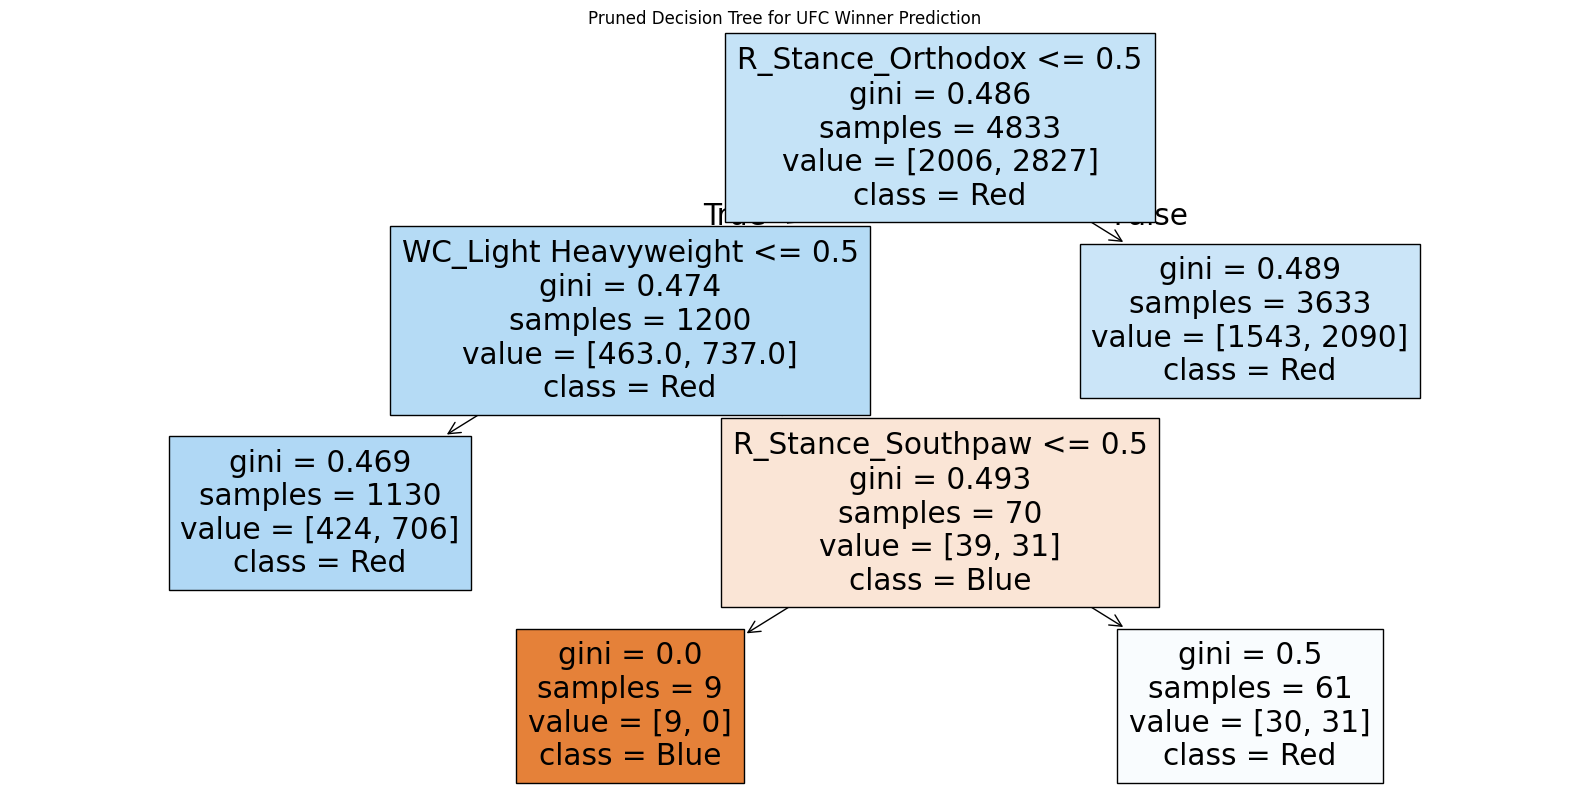

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Preprocessing (assuming 'df' is your DataFrame)
df.loc[df["Winner"] == "Red", "Winner"] = 1
df.loc[df["Winner"] == "Blue", "Winner"] = 0
df["Winner"] = pd.to_numeric(df["Winner"])

# Separate LabelBinarizer instances for each categorical variable
lb_weight = LabelBinarizer()
lb_red_stance = LabelBinarizer()
lb_blue_stance = LabelBinarizer()

W_class = lb_weight.fit_transform(df["WeightClass"])
W_class_labels = lb_weight.classes_
W_class_columns = [f"WC_{cls}" for cls in W_class_labels]

R_Stance = lb_red_stance.fit_transform(df["RedStance"])
R_stance_labels = lb_red_stance.classes_
R_stance_columns = [f"R_Stance_{cls}" for cls in R_stance_labels]

B_Stance = lb_blue_stance.fit_transform(df["BlueStance"])
B_stance_labels = lb_blue_stance.classes_
B_stance_columns = [f"B_Stance_{cls}" for cls in B_stance_labels]

X = np.concatenate((W_class, R_Stance, B_Stance), axis=1)
feature_names = W_class_columns + R_stance_columns + B_stance_columns

X = pd.DataFrame(X, columns=feature_names)
y = df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

### Unpruned Tree ###

# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

# Obviously overfit the data
train_accuracy_unpruned = accuracy_score(y_train, y_train_pred_unpruned)
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f"Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}")
print(f"Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}")

# Plot the unpruned tree
plt.figure(figsize=(20, 10))
plot_tree(
    unpruned_clf, feature_names=feature_names, class_names=["Blue", "Red"], filled=True
)
plt.title("Unpruned Decision Tree for UFC Winner Prediction")
plt.show()

### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Remove the maximum value of alpha (as it would prune all leaves)
ccp_alphas = ccp_alphas[:-1]

clfs = []
cv_means = []
cv_stds = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    clfs.append(clf)
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

# Find the optimal ccp_alpha
max_mean = max(cv_means)
optimal_alpha_indices = [
    i for i, mean in enumerate(cv_means) if mean >= max_mean - cv_stds[i]
]
best_alpha_index = optimal_alpha_indices[
    -1
]  # Choose the largest alpha for simpler tree
best_ccp_alpha = ccp_alphas[best_alpha_index]

# Train the final model with the best ccp_alpha on the entire training set
best_clf = DecisionTreeClassifier(random_state=13, ccp_alpha=best_ccp_alpha)
best_clf.fit(X_train, y_train)

print(f"Best ccp_alpha: {best_ccp_alpha}")
print(f"Cross-validated accuracy with best ccp_alpha: {cv_means[best_alpha_index]}")

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f"Pruned Tree - Training Accuracy: {train_accuracy_pruned}")
print(f"Pruned Tree - Test Accuracy: {test_accuracy_pruned}")

# Plot the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf, feature_names=feature_names, class_names=["Blue", "Red"], filled=True
)
plt.title("Pruned Decision Tree for UFC Winner Prediction")
plt.show()

# Multilayer Perceptron Model

In [ ]:
from sklearn.neural_network import MLPClassifier

df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

# Define the feature columns and the target column
features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
            'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
            'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#            ,"Red_Favorite"
            ]
X = df[features]
y = df['Winner']

# test/train split, using the same random seed as the decision tree model for comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

mlp = MLPClassifier(max_iter=500, random_state=13, batch_size = 250)

# cross validation to determine best parameters
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
}
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
mlp.set_params(**grid_search.best_params_)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

{'alpha': 0.0001, 'hidden_layer_sizes': (20,)}
Accuracy: 0.5773366418527709


#Random Forest

Best Parameters found by GridSearchCV:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest - Training Accuracy: 0.6525967308090214
Random Forest - Test Accuracy: 0.5922249793217536


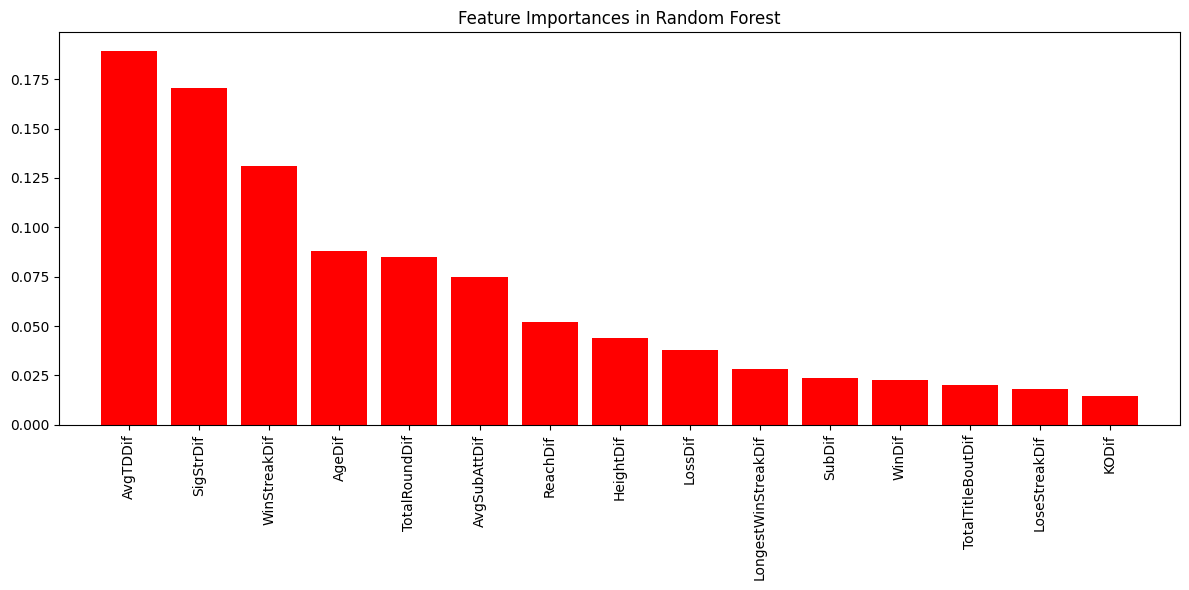

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Preprocessing
df.loc[df["Winner"] == "Red", "Winner"] = 1
df.loc[df["Winner"] == "Blue", "Winner"] = 0
df["Winner"] = pd.to_numeric(df["Winner"])

# Feature selection
features = [
    "LoseStreakDif",
    "WinStreakDif",
    "LongestWinStreakDif",
    "WinDif",
    "LossDif",
    "TotalRoundDif",
    "TotalTitleBoutDif",
    "KODif",
    "SubDif",
    "HeightDif",
    "ReachDif",
    "AgeDif",
    "SigStrDif",
    "AvgSubAttDif",
    "AvgTDDif",
#    "Red_Favorite"
]
X = df[features]
y = df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

### Random Forest with Cross-Validation ###

param_grid = {
    "n_estimators": [3, 10, 50, 100],  # Number of trees in the forest.
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=13)

grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy"
)

grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_clf = grid_search.best_estimator_

y_train_pred_rf = best_rf_clf.predict(X_train)
y_test_pred_rf = best_rf_clf.predict(X_test)

# Calculate accuracies
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"\nRandom Forest - Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest - Test Accuracy: {test_accuracy_rf}")

# Plot feature importances
# calculated based on the impurity reduction achieved by splitting on a feature.
# The impurity reduction comes from using metrics like the Gini Index or Entropy to measure how well a feature splits the data into homogeneous groups
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(len(features)), importances[indices], color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

Random forest with only stance and weight class

Best Parameters found by GridSearchCV:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}

Random Forest - Training Accuracy: 0.5886612869853093
Random Forest - Test Accuracy: 0.5740281224152192


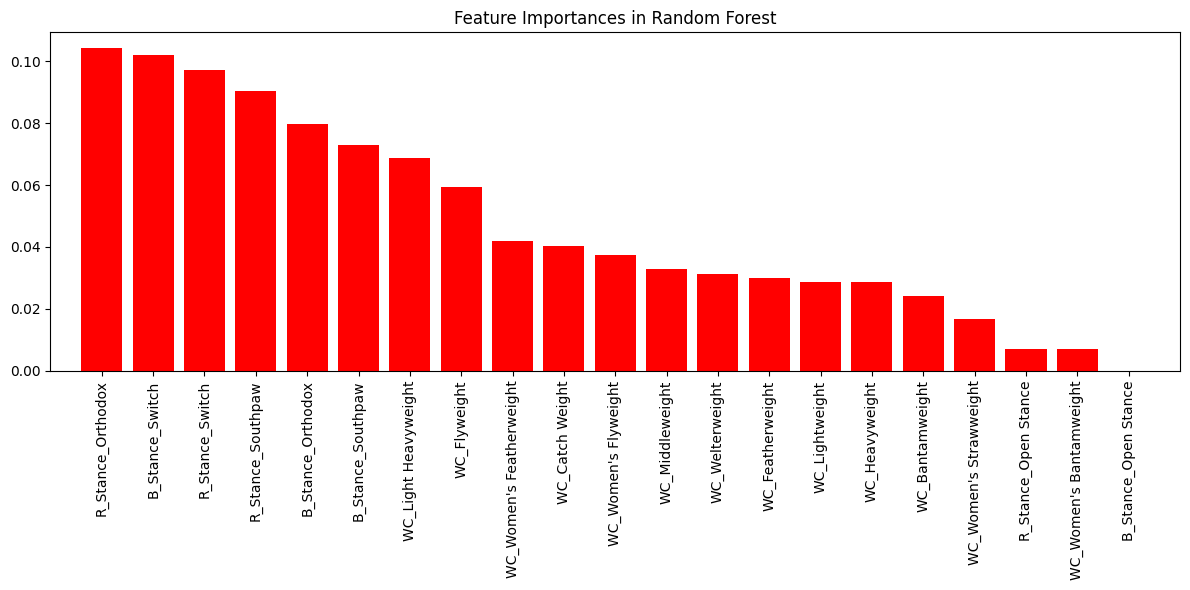

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

# Preprocessing (assuming 'df' is your DataFrame)
df.loc[df["Winner"] == "Red", "Winner"] = 1
df.loc[df["Winner"] == "Blue", "Winner"] = 0
df["Winner"] = pd.to_numeric(df["Winner"])

# Separate LabelBinarizer instances for each categorical variable
lb_weight = LabelBinarizer()
lb_red_stance = LabelBinarizer()
lb_blue_stance = LabelBinarizer()

W_class = lb_weight.fit_transform(df["WeightClass"])
W_class_labels = lb_weight.classes_
W_class_columns = [f"WC_{cls}" for cls in W_class_labels]

R_Stance = lb_red_stance.fit_transform(df["RedStance"])
R_stance_labels = lb_red_stance.classes_
R_stance_columns = [f"R_Stance_{cls}" for cls in R_stance_labels]

B_Stance = lb_blue_stance.fit_transform(df["BlueStance"])
B_stance_labels = lb_blue_stance.classes_
B_stance_columns = [f"B_Stance_{cls}" for cls in B_stance_labels]

X = np.concatenate((W_class, R_Stance, B_Stance), axis=1)
feature_names = W_class_columns + R_stance_columns + B_stance_columns

X = pd.DataFrame(X, columns=feature_names)
y = df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

### Random Forest with Cross-Validation ###

param_grid = {
    "n_estimators": [3, 10, 50, 100],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
}

rf_clf = RandomForestClassifier(random_state=13)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy"
)

# Fit the model to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_clf = grid_search.best_estimator_

# Make predictions with the best estimator
y_train_pred_rf = best_rf_clf.predict(X_train)
y_test_pred_rf = best_rf_clf.predict(X_test)

# Calculate accuracies
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"\nRandom Forest - Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest - Test Accuracy: {test_accuracy_rf}")

# Plot feature importances
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = feature_names

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(len(features)), importances[indices], color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

##XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Selecting features for the model based on EDA and stance analysis
features = ['RedStance', 'BlueStance', 'WeightClass', 'TitleBout',
            'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
            'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
            'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#            ,"Red_Favorite"
            ]

df_encoded = pd.get_dummies(df, columns=['RedStance', 'BlueStance', 'WeightClass', 'TitleBout'
#                                         ,"Red_Favorite"
                                         ], drop_first=True)

# Re-check the updated feature names after encoding to select correctly
encoded_features = [col for col in df_encoded.columns if any(f in col for f in features)]

X = df_encoded[encoded_features]
y = df_encoded['Winner']  # Encoding 'Red' as 1 and 'Blue' as 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.618693134822167
              precision    recall  f1-score   support

           0       0.54      0.46      0.50       491
           1       0.66      0.73      0.69       718

    accuracy                           0.62      1209
   macro avg       0.60      0.59      0.59      1209
weighted avg       0.61      0.62      0.61      1209



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, np.sum(y == 0) / np.sum(y == 1)],  # Set to balance classes if needed
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='accuracy',
    n_iter=50,
    cv=skf,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model based on the random search
best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC calculation

test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test ROC-AUC: {test_roc_auc}")
print("\nClassification Report on Test Set:")
print(classification_report_output)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 0.7150156116945785, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Test Accuracy: 0.6542597187758478
Test ROC-AUC: 0.6722183140540878

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       491
           1       0.70      0.73      0.71       718

    accuracy                           0.65      1209
   macro avg       0.64      0.64      0.64      1209
weighted avg       0.65      0.65      0.65      1209



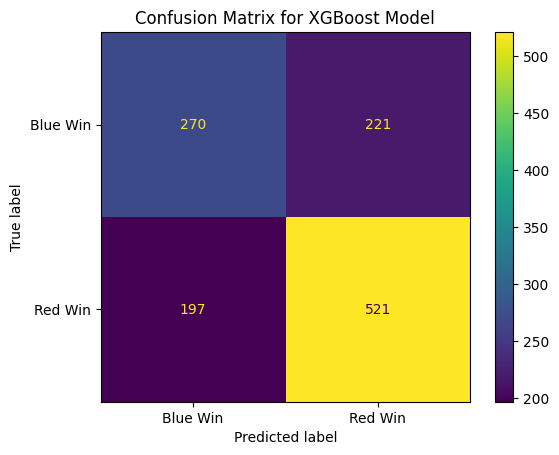

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, display_labels=['Blue Win', 'Red Win'])
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

One factor that was noticed before utilizing pruning was the severe problem of overfitting. As shown previously, the decision tree achieved a training accuracy of approximately 99%, but a testing accuracy of only 53%. Hence, a way to bypass this is through XGBoost, as it includes regularization parameters to prevent overfitting, and combines multiple decision trees using boosting, which improves accuracy by reducing errors and overfitting.

Through a Randomized Search Cross Validation, parameters were optimized, and finally achieved a higher testing accuracy than the previously implemented Decision Tree.

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



random_search.fit(X_train, y_train)
best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC calculation

test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test ROC-AUC: {test_roc_auc}")
print("\nClassification Report on Test Set:")
print(classification_report_output)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 0.7150156116945785, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Test Accuracy: 0.6542597187758478
Test ROC-AUC: 0.6722183140540878

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       491
           1       0.70      0.73      0.71       718

    accuracy                           0.65      1209
   macro avg       0.64      0.64      0.64      1209
weighted avg       0.65      0.65      0.65      1209

